<a href="https://colab.research.google.com/github/revanthbethala/shoreline_extraction/blob/main/shoreline_change_geojson_download.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
# import ee
# import geemap
# from datetime import datetime

# # Authenticate and initialize Earth Engine
# ee.Authenticate()
# ee.Initialize(project="ee-revanthbethala")

# # Define the area of interest (AOI)
# # coords = [[81.2365, 16.2475], [81.2465, 16.2425], [81.2565, 16.2395]]
# place = ee.Geometry.LineString(coords)

# # NDWI functions
# def add_ndwi_l5(image):
#     green = image.select('SR_B2').multiply(0.0001)
#     nir = image.select('SR_B4').multiply(0.0001)
#     ndwi = green.subtract(nir).divide(green.add(nir)).rename('NDWI')
#     return image.addBands(ndwi)

# def add_ndwi_l7(image): return add_ndwi_l5(image)
# def add_ndwi_l8_9(image):
#     green = image.select('SR_B3').multiply(0.0001)
#     nir = image.select('SR_B5').multiply(0.0001)
#     ndwi = green.subtract(nir).divide(green.add(nir)).rename('NDWI')
#     return image.addBands(ndwi)

# def add_ndwi_s2(image):
#     green = image.select('B3').multiply(0.0001)
#     nir = image.select('B8').multiply(0.0001)
#     ndwi = green.subtract(nir).divide(green.add(nir)).rename('NDWI')
#     return image.addBands(ndwi)

# # Add precipitation band
# def add_environmental_covariates(image):
#     date = ee.Date(image.get('system:time_start'))
#     era5 = ee.ImageCollection('ECMWF/ERA5/DAILY').filterDate(date, date.advance(1, 'day')).first()
#     precipitation = ee.Algorithms.If(era5, era5.select('total_precipitation').rename('precipitation'), ee.Image(0).rename('precipitation'))
#     return image.addBands(ee.Image(precipitation))

# # Year and seasons
# start_year = 2020
# end_year = 2021
# seasons = [
#     {'name': 'monsoon', 'start': '-06-01', 'end': '-09-30'},
#     {'name': 'non-monsoon', 'start': '-10-01', 'end': '-05-31'}
# ]

# # Map initialization
# Map = geemap.Map(center=[16.2435, 81.2465], zoom=12)
# shoreline_info = []

# # Processing loop
# for year in range(start_year, end_year + 1):
#     sensors = [{'id': 'LANDSAT', 'start_year': 1994, 'end_year': 2024}]
#     if year >= 2015:
#         sensors.append({'id': 'SENTINEL2', 'start_year': 2015, 'end_year': 2024})

#     for sensor in sensors:
#         for season in seasons:
#             # Handle cross-year season
#             if season['name'] == 'non-monsoon' and season['start'] > season['end']:
#                 start_date = f"{year-1}{season['start']}"
#                 end_date = f"{year}{season['end']}"
#             else:
#                 start_date = f"{year}{season['start']}"
#                 end_date = f"{year}{season['end']}"

#             print(f"\nProcessing {year} {season['name']} {sensor['id']} from {start_date} to {end_date}...")

#             # Choose image collection and NDWI function
#             if sensor['id'] == 'LANDSAT':
#                 if year <= 2011:
#                     collection_id = "LANDSAT/LT05/C02/T1_L2"
#                     ndwi_func = add_ndwi_l5
#                 elif year <= 2013:
#                     collection_id = "LANDSAT/LE07/C02/T1_L2"
#                     ndwi_func = add_ndwi_l7
#                 elif year <= 2021:
#                     collection_id = "LANDSAT/LC08/C02/T1_L2"
#                     ndwi_func = add_ndwi_l8_9
#                 else:
#                     collection_id = "LANDSAT/LC09/C02/T1_L2"
#                     ndwi_func = add_ndwi_l8_9
#             else:
#                 collection_id = "COPERNICUS/S2_SR"
#                 ndwi_func = add_ndwi_s2

#             # Load and filter collection
#             collection = (
#                 ee.ImageCollection(collection_id)
#                 .filterBounds(place)
#                 .filterDate(start_date, end_date)
#                 .filter(ee.Filter.lt('CLOUD_COVER' if 'LANDSAT' in collection_id else 'CLOUDY_PIXEL_PERCENTAGE', 50))
#                 .map(ndwi_func)
#                 .map(add_environmental_covariates)
#             )

#             # Check image count
#             image_count = collection.size().getInfo()
#             print(f"Number of images: {image_count}")
#             if image_count == 0:
#                 print("No images found for this time period.")
#                 continue

#             # Safe info print
#             try:
#                 print("Sample image info:")
#                 print(collection.first().getInfo())
#             except Exception as e:
#                 print(f"Error fetching image info: {e}")
#                 continue

#             # Limit to first 3 images per season
#             image_list = collection.toList(collection.size())
#             for i in range(min(image_count, 3)):
#                 image = ee.Image(image_list.get(i))

#                 ndwi = image.select('NDWI')
#                 water_mask = ndwi.gt(0.2)

#                 # Extract shoreline as vector
#                 # Step 1: Reduce to polygons
#                 shoreline_fc = water_mask.reduceToVectors(
#                     geometry=place,
#                     scale=10 if 'S2_SR' in collection_id else 30,
#                     geometryType='polygon',
#                     maxPixels=1e9
#                 )
#                 def polygon_to_line(feature):
#                   coords = feature.geometry().coordinates()
#                   line = ee.Geometry.LineString(coords.get(0))  # outer ring
#                   return ee.Feature(line)

#                 shoreline_lines = shoreline_fc.map(polygon_to_line)
#                 # Step 2: Convert polygons to boundary lines

#                 # Step 3: Visualize or process
#                 # Map.addLayer(shoreline_lines, {'color': 'red'}, f"Shoreline Line {date}")


#                 # Date and precipitation
#                 date = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd').getInfo()
#                 try:
#                     precipitation = image.select('precipitation').reduceRegion(
#                         reducer=ee.Reducer.mean(),
#                         geometry=place,
#                         scale=10 if 'S2_SR' in collection_id else 30
#                     ).get('precipitation').getInfo() or 0
#                 except:
#                     precipitation = 0

#                 shoreline_info.append({
#                     'year': year,
#                     'season': season['name'],
#                     'sensor': sensor['id'],
#                     'date': date,
#                     'precipitation': precipitation
#                 })

#                 print(f"\nImage {i+1}: {year} {season['name']} {sensor['id']} ({date})")
#                 print(f"Precipitation: {precipitation:.4f} m")

#                 # Add to map
#                 Map.addLayer(water_mask, {'palette': ['blue'], 'opacity': 0.5}, f"Water Mask {date}")
#                 Map.addLayer(shoreline_fc, {'color': 'red'}, f"Shoreline {date}")
#                 Map.addLayer(place, {'color': 'yellow'}, 'AOI')

# print("\nDisplaying shoreline results on interactive map...")
# Map

In [27]:
import ee
import json
import geemap
ee.Authenticate()
ee.Initialize(project="ee-revanthbethala")

In [28]:

with open('/content/bunder-coords.geojson') as f:
    geojson = json.load(f)

# Convert to Earth Engine Geometry or FeatureCollection
aoi = ee.FeatureCollection(geojson)

# If the AOI contains LineStrings and you want to buffer them:
buffered_aoi = aoi.geometry().buffer(1000)


In [29]:
def add_ndwi_l5(image):
    green = image.select('SR_B2').multiply(0.0001)
    nir = image.select('SR_B4').multiply(0.0001)
    ndwi = green.subtract(nir).divide(green.add(nir)).rename('NDWI')
    return image.addBands(ndwi)
def add_ndwi_l7(image):
    green = image.select('SR_B2').multiply(0.0001)
    nir = image.select('SR_B4').multiply(0.0001)
    ndwi = green.subtract(nir).divide(green.add(nir)).rename('NDWI')
    return image.addBands(ndwi)
def add_ndwi_l8_9(image):
    green = image.select('SR_B3').multiply(0.0001)
    nir = image.select('SR_B5').multiply(0.0001)
    ndwi = green.subtract(nir).divide(green.add(nir)).rename('NDWI')
    return image.addBands(ndwi)
def add_ndwi_s2(image):
    green = image.select('B3').multiply(0.0001)
    nir = image.select('B8').multiply(0.0001)
    ndwi = green.subtract(nir).divide(green.add(nir)).rename('NDWI')
    return image.addBands(ndwi)

In [30]:
def fetch_images(year, start_date, end_date, buffer_months=2, cloud_thresh=70):
    from datetime import datetime, timedelta
    # Extend dates if needed
    start_dt = datetime.strptime(f"{year}-{start_date}", "%Y-%m-%d") - timedelta(days=buffer_months*30)
    end_dt = datetime.strptime(f"{year}-{end_date}", "%Y-%m-%d") + timedelta(days=buffer_months*30)
    start_str, end_str = start_dt.strftime("%Y-%m-%d"), end_dt.strftime("%Y-%m-%d")
    # Collection/year selection
    if year <= 2011:
        cid, ndwi_fun, scale, cloud_key = "LANDSAT/LT05/C02/T1_L2", add_ndwi_l5, 30, 'CLOUD_COVER'
    elif 2012 <= year <= 2013:
        cid, ndwi_fun, scale, cloud_key = "LANDSAT/LE07/C02/T1_L2", add_ndwi_l7, 30, 'CLOUD_COVER'
    elif 2014 <= year <= 2021:
        cid, ndwi_fun, scale, cloud_key = "LANDSAT/LC08/C02/T1_L2", add_ndwi_l8_9, 30, 'CLOUD_COVER'
    else:
        cid, ndwi_fun, scale, cloud_key = "COPERNICUS/S2_SR", add_ndwi_s2, 10, 'CLOUDY_PIXEL_PERCENTAGE'
    collection = (ee.ImageCollection(cid)
                  .filterBounds(aoi)
                  .filterDate(start_str, end_str)
                  .filter(ee.Filter.lt(cloud_key, cloud_thresh))
                  .map(ndwi_fun)
                  .select('NDWI'))
    return collection, scale


In [31]:
def shoreline_vector(water_mask, scale):
    return water_mask.reduceToVectors(
        geometry=aoi, scale=scale, geometryType='polygon', maxPixels=1e9)


In [ ]:
years = range(1994, 2008)
season_start, season_end = "06-01", "09-30"  # You can make this a loop for seasons

Map = geemap.Map(center=[16.245, 81.246], zoom=12)
Map.addLayer(aoi, {}, "AOI")

for y in years:
    # Try normal, else relax filters as needed
    coll, scale = fetch_images(y, season_start, season_end, buffer_months=0, cloud_thresh=50)
    count = coll.size().getInfo()
    if count < 10:
        coll, scale = fetch_images(y, season_start, season_end, buffer_months=2, cloud_thresh=70)
        count = coll.size().getInfo()
    if count == 0:
        print(f"{y}: No data available even after relaxation.")
        continue
    median_ndwi = coll.median()
    water_mask = median_ndwi.gt(0.2)
    shoreline_fc = shoreline_vector(water_mask, scale)
    # Visualize on map
    Map.addLayer(shoreline_fc.style(color='blue', width=2), {}, f'Shoreline {y}')
    print(f"{y}: Shoreline vector visualized. Images used: {count}")
    # Optional: Export vector to Google Drive (one year at a time)
    task = ee.batch.Export.table.toDrive(
        collection=shoreline_fc,
        description=f'shoreline_{y}',
        folder='Shoreline_Results',
        fileFormat='GeoJSON'
    )
    task.start()
Map

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded shoreline for year 1994
Loaded shoreline for year 1995
Loaded shoreline for year 1997
Loaded shoreline for year 2000
Loaded shoreline for year 2001
Loaded shoreline for year 2003
Loaded shoreline for year 2004
Loaded shoreline for year 2005
Loaded shoreline for year 2006
Loaded shoreline for year 2007
Shoreline CRS example: EPSG:4326
Transects CRS: None


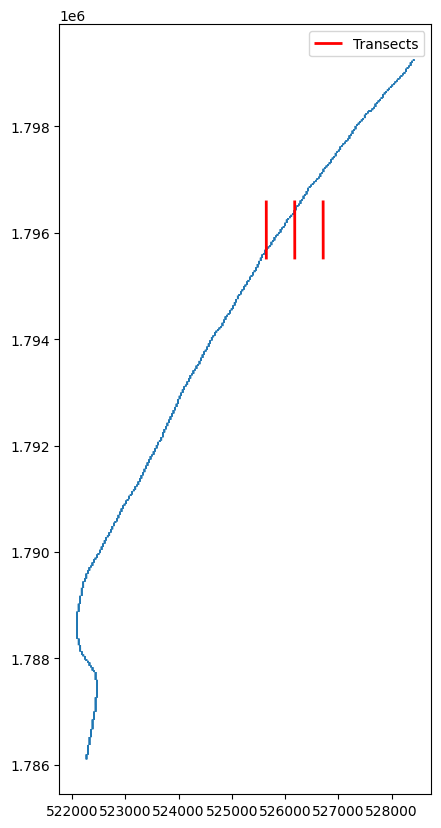

Year: 1994 NSM per transect: [nan nan nan]
Year: 1995 NSM per transect: [nan nan nan]
Year: 1997 NSM per transect: [nan nan nan]
Year: 2000 NSM per transect: [nan nan nan]
Year: 2001 NSM per transect: [nan nan nan]
Year: 2003 NSM per transect: [nan nan nan]
Year: 2004 NSM per transect: [nan nan nan]
Year: 2005 NSM per transect: [nan nan nan]
Year: 2006 NSM per transect: [nan nan nan]
Year: 2007 NSM per transect: [nan nan nan]


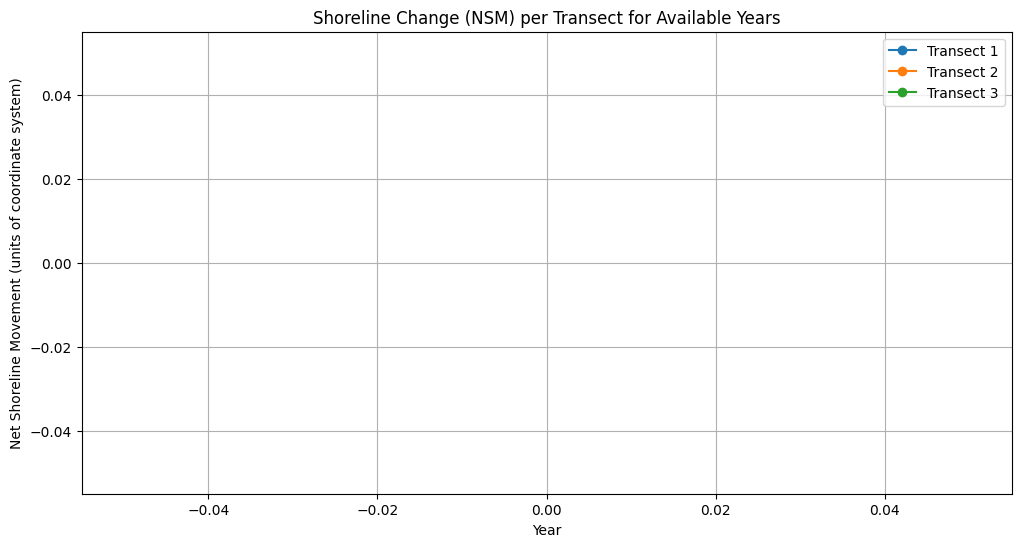

In [38]:
# Install necessary libraries (if not already installed)
# !pip install geopandas shapely matplotlib

import os
import geopandas as gpd
from shapely.geometry import LineString, Point
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

# Mount Google Drive to access your data
drive.mount('/content/drive')

# Define path to your shoreline GeoJSON folder within Drive
data_folder = '/content/drive/MyDrive/Shoreline_Results'

# List GeoJSON files for years 1994 to 2007
years = range(1994, 2008)
geojson_files = [os.path.join(data_folder, f'shoreline_{year}.geojson') for year in years]

# Load GeoJSONs into geopandas GeoDataFrames dictionary
shorelines = {}
for year, path in zip(years, geojson_files):
    if os.path.exists(path):
        shorelines[year] = gpd.read_file(path)
        print(f"Loaded shoreline for year {year}")
    else:
        print(f"Warning: GeoJSON missing for year {year}")

# Example: Define simple shore-normal transects manually
# UPDATE THIS with your own transect coordinates if you have better ones
transect_points = [
    ((81.24, 16.24), (81.24, 16.25)),
    ((81.245, 16.24), (81.245, 16.25)),
    ((81.25, 16.24), (81.25, 16.25))
]
transects = [LineString([p1, p2]) for p1, p2 in transect_points]
transect_gdf = gpd.GeoDataFrame({'geometry': transects})
# Print CRS of one shoreline layer and transect layer



import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,10))
for year, gdf in shorelines.items():
    gdf.plot(ax=ax, label=f'Shoreline {year}', alpha=0.5)
transect_gdf.plot(ax=ax, color='red', linewidth=2, label='Transects')
plt.legend()
plt.show()

# Function: Find nearest intersection distance along a transect
def shoreline_intersection_distance(shoreline_gdf, transect_line):
    intersections = shoreline_gdf.geometry.intersection(transect_line)
    points = []
    # Sometimes intersects as multipoint or geometrycollection, handle accordingly
    for inter in intersections:
        if inter.is_empty:
            continue
        if inter.geom_type == 'Point':
            points.append(inter)
        elif inter.geom_type == 'MultiPoint':
            points.extend([p for p in inter.geoms])
        elif inter.geom_type == 'GeometryCollection':
            for geom in inter.geoms:
                if geom.geom_type == 'Point':
                    points.append(geom)
    if not points:
        return np.nan
    origin = Point(transect_line.coords[0])
    distances = [origin.distance(p) for p in points]
    return min(distances)

# Choose baseline reference year (1994) to compute change relative to it
baseline_year = 1994
if baseline_year not in shorelines:
    raise FileNotFoundError(f"Baseline year {baseline_year} shoreline file not found")

# Compute NSM for each year compared to baseline
nsm_results = {}
for year, gdf in shorelines.items():
    distances_base = [shoreline_intersection_distance(shorelines[baseline_year], t) for t in transect_gdf.geometry]
    distances_year = [shoreline_intersection_distance(gdf, t) for t in transect_gdf.geometry]

    # Convert to numpy arrays and compute difference
    distances_base = np.array(distances_base)
    distances_year = np.array(distances_year)
    nsm = distances_year - distances_base
    nsm_results[year] = nsm

    print(f"Year: {year} NSM per transect: {nsm}")

# Optional: Plot NSM over years for each transect
plt.figure(figsize=(12, 6))
# Use the keys of the nsm_results dictionary to get the actual years with data
years_with_data = sorted(nsm_results.keys())
for i in range(len(transects)):
    transect_nsm_values = [nsm_results[year][i] for year in years_with_data]
    plt.plot(years_with_data, transect_nsm_values, marker='o', label=f'Transect {i+1}')

plt.xlabel('Year')
plt.ylabel('Net Shoreline Movement (units of coordinate system)')
plt.title('Shoreline Change (NSM) per Transect for Available Years')
plt.legend()
plt.grid(True)
plt.show()